# Import Libraries

In [1]:
import pickle as pkl

from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, AnchoredText
from mpl_toolkits import mplot3d

import networkx as nx

import astropy.wcs as wcs
from astropy.coordinates import SkyCoord

import subprocess

# Load Detections from File

These detections generated by the run_pipeline script.

In [2]:
output_directory = "/home/fwang/20190607run.pkl"

In [3]:
f = open(output_directory, "rb")

In [4]:
def load(fileobj):
    while True:
        try:
            yield pkl.load(fileobj)
        except EOFError:
            break

In [5]:
top_imgs_list = []
norm_imgs_list = []
preds_list = []
top_bnds_list = []
slices_list = []
binary_imgs_list = []
indexes = []
triplets_list = []
arguments = []
for val in load(f):
    if isinstance(val[0], Exception):
        arguments.append(val[2])
        continue
    arguments.append(val[7])
    if len(val[0]) > 0:
        top_imgs_list.append(val[0])
        norm_imgs_list.append(val[1])
        preds_list.append(val[2])
        top_bnds_list.append(val[3])
        slices_list.append(val[4])
        binary_imgs_list.append(val[5])
        indexes.append(val[6])
        triplets_list.append(val[7])

In [6]:
top_imgs_list_flat = [val for l in top_imgs_list for val in l]
norm_imgs_list_flat = [val for l in norm_imgs_list for val in l]
preds_list_flat = [val for l in preds_list for val in l]
top_bnds_list_flat = [val for l in top_bnds_list for val in l]
slices_list_flat = [val for l in slices_list for val in l]
binary_imgs_list_flat = [val for l in binary_imgs_list for val in l]
indexes_list_flat = [indexes[i] for i in range(len(preds_list)) for j in range(len(preds_list[i]))]
triplets_list_flat = [triplets_list[i] for i in range(len(preds_list)) for j in range(len(preds_list[i]))]

# Keep Track of Multiple Detections in the Same Image

If there are multiple detections in the same image, it is possible they belong to a manmade satellite moving across the image. During manual filtering of detections, this information is used to filter out satellites.

In [10]:
points = []
for i in range(len(top_bnds_list)):
    if len(top_bnds_list[i]) >= 2:
        midpoints = []
        for j in range(len(top_bnds_list[i])):
            midpoints.append(((top_bnds_list[i][j][0][0] + top_bnds_list[i][j][1][0]) // 2, (top_bnds_list[i][j][0][1] + top_bnds_list[i][j][1][1]) // 2))
        for j in range(len(top_bnds_list[i])):
            points.append((midpoints, midpoints[j]))
    else:
        points.append([])

# View Image function

Allows me to view a detection (science and reference images, along with the positions of other detections in the same frame if they exist) with the ID $i$.

In [12]:
def view_image(i):
    
    if len(points[i]) != 0:
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        
        all_points, point = points[i]
        all_points = np.array(all_points)
        
        minx, maxx = np.min(all_points[:, 0]), np.max(all_points[:, 0])
        miny, maxy = np.min(all_points[:, 1]), np.max(all_points[:, 1])
        maxx = max(maxx, minx + maxy - miny)
        maxy = max(maxy, miny + maxx - minx)
        minx -= 100
        miny -= 100
        maxx += 100
        maxy += 100
        
        ax[2].plot(*all_points.T, marker="o", c="blue", zorder=0)
        ax[2].scatter(*point, c="orange", marker="o", zorder=1)
        ax[2].set_xlim(minx, maxx)
        ax[2].set_ylim(miny, maxy)
        fig.gca().invert_yaxis()
    else:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    sci, ref = norm_imgs_list_flat[i]
    ax[0].imshow(sci, cmap="gray")
    ax[1].imshow(ref, cmap="gray")
    
    pred = preds_list_flat[i]
    fig.suptitle(str(pred) + " " + str(i))
    
    plt.show()

# Positions

Convert all the detections from pixel space to world coordinate space (right ascension and declination)

In [9]:
positions = []
for index in tqdm(list(range(len(top_bnds_list_flat)))):
    pos = top_bnds_list_flat[index]
    pos = [[(pos[0][0] + pos[1][0]) // 2, (pos[0][1] + pos[1][1]) // 2]]
    wcs_ref = wcs.WCS(arguments[indexes_list_flat[index]][1])
    ra, dec = zip(*wcs_ref.all_pix2world(np.array(pos), 0, ra_dec_order=True))
    positions.append((ra, dec))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# Obtain linkages which are over 5 deg/day and under 50 deg/day
Objects above 50 deg/day are often sattelite trails. All the linkages are stored in an undirected graph.

In [16]:
times = [float("0." + arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1][8:]) for i in range(len(top_bnds_list_flat))]

ok_pairs = []
interesting_indexes = []
G = nx.DiGraph()
for i in tqdm(list(range(len(top_bnds_list_flat)))):
    
    if len(points[i]) != 0 and len(points[i][0]) >= 3:
        continue
    
    for j in range(i + 1, len(top_bnds_list_flat)):

        if len(points[j]) != 0 and len(points[j][0]) >= 3:
            continue
    
        if times[i] == times[j]:
            continue
        
        ra1, dec1 = positions[i]
        ra2, dec2 = positions[j]
        
        ra1 = ra1[0]
        dec1 = dec1[0]
        ra2 = ra2[0]
        dec2 = dec2[0]

        disp = ((dec2-dec1) ** 2 + (ra2-ra1)**2) ** 0.5
        
        if disp / abs(times[i] - times[j]) < 50 and disp / abs(times[i] - times[j]) > 5:
         # Obtain linkages which are over 5 deg/day and under 50 deg/day
Objects above 50 deg/day are often sattelite trails. All the linkages are stored in an undirected graph.   ok_pairs.append((i, j, disp / abs(times[i] - times[j])))
            interesting_indexes.append(i)
            interesting_indexes.append(j)
            if times[i] < times[j]:
                G.add_edge(i, j, weight=disp / abs(times[i] - times[j]), disp=disp, times=[times[i], times[j]], pos=[(ra1, dec1), (ra2, dec2)])
            else:
                G.add_edge(j, i, weight=disp / abs(times[i] - times[j]), disp=disp, times=[times[j], times[i]], pos=[(ra2, dec2), (ra1, dec1)])
interesting_indexes = set(interesting_indexes)

# Remove stationary detections
Any transients that are detected multiple times in the same spot are removed. To prevent the removal of asteroids, the motion rate between detections must be under 0.5 deg/day.

In [17]:
bad_list = []
indexes = list(G.nodes)
for i in tqdm(indexes):
    for j in indexes:
        if i == j or times[i] == times[j]:
            continue
        ra1, dec1 = positions[i]
        ra2, dec2 = positions[j]
        
        ra1 = ra1[0]
        dec1 = dec1[0]
        ra2 = ra2[0]
        dec2 = dec2[0]
        
        disp = ((dec2-dec1) ** 2 + (ra2-ra1)**2) ** 0.5
        
        if disp < 0.008333333 and disp/abs(times[j] - times[i]) < 0.5: # within 30 arcseconds
            bad_list.append((i, j))
            G.remove_node(i)
            break

In [18]:
print("NUMBER OF DETECTIONS:", len(G))

NUMBER OF DETECTIONS: 3533


# Visually vet detections and obtain a set of true streaks
Detections are processed in batches (500 at a time), and true positives are added to the list "good_list". After every batch, the false detections are removed from the graph and any isolated nodes are then removed since they do not have any linkages.

For brevity, only 10 images are shown for the cells.

In [19]:
good_list = []

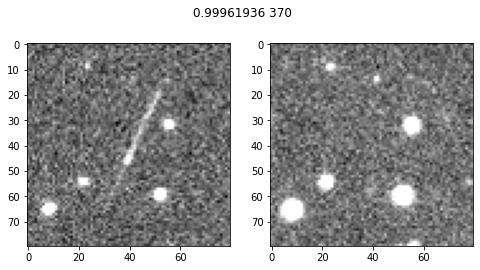

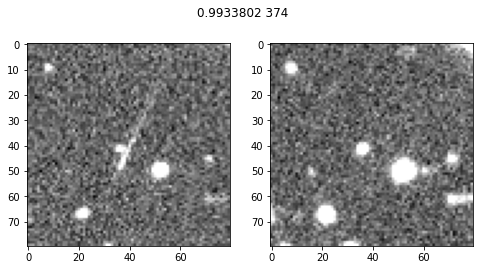

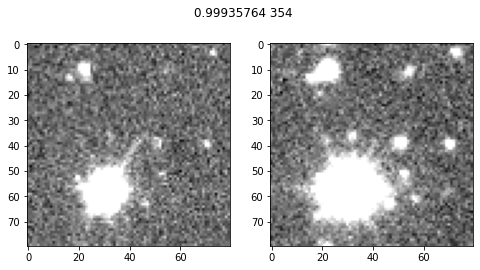

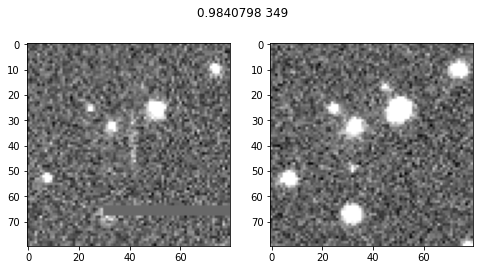

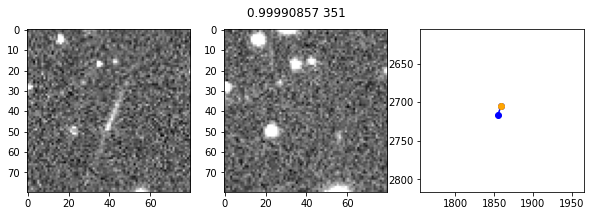

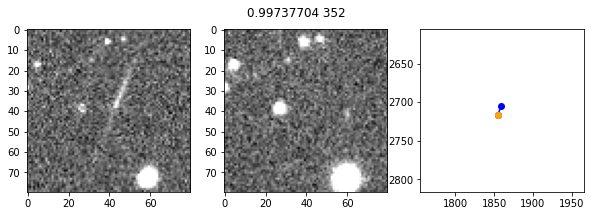

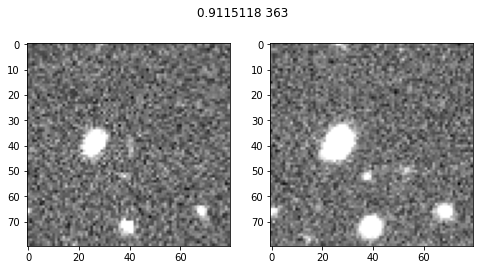

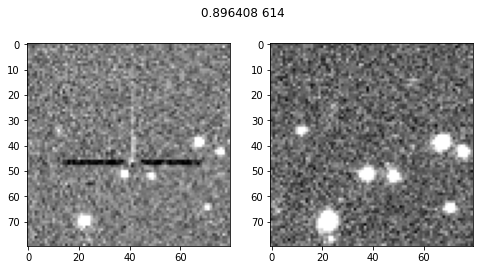

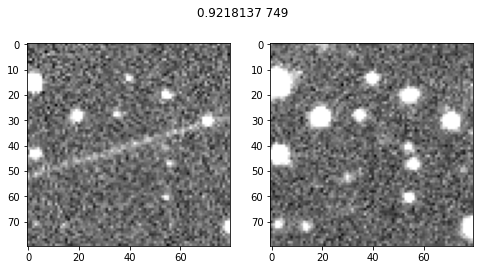

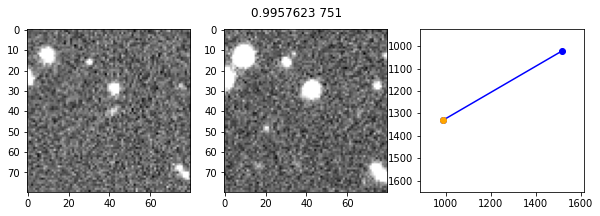

In [22]:
%matplotlib inline

batch_size = 500

sort_degs = sorted(G.degree, key=lambda x: x[1], reverse=True)

for i, deg in sort_degs[:batch_size]:
    if i not in good_list:
        view_image(i)

In [23]:
# update list of good positive detections
good_list = [370, 354, 750, 611, 924, 925, 763, 928, 927, 347, 753, 754, 381, 616, 532, 581, 530, 762, 547, 1670, 2550, 364, 556, 546, 997, 544, 6609, 346, 2395, 1657, 2645, 4000, 2407, 378, 4005, 5808, 2555, 3994, 2581, 2610, 3986, 555, 3976, 3973, 4427, 2394, 4535, 3966, 3939, 4003, 4450, 3960, 1669, 3945, 4501, 1655, 2399, 3928, 3940, 4538, 2429, 3911, 4458, 3895, 337, 383, 2554, 3891, 4541, 549, 553, 3874, 3882, 4465, 397, 3778, 4454, 4457, 4479, 2420, 2956, 945, 951, 2680, 4487, 4480, 4702, 3741, 774, 398, 2855, 3809, 915, 783, 2813, 4412, 3793, 2565, 2640, 3933, 3781, 3981, 3776, 3764, 3752, 3582, 3604, 3592, 3606, 3616, 3913, 2677, 4411, 3703, 3735, 3746, 3573, 3828, 4013, 3643, 3679, 3687, 3696, 3543, 3630, 3956, 2405, 3654, 3662, 3669, 3716, 3722, 3890, 3531, 3995, 3523, 3509, 3510, 2867, 3489, 2851, 3481, 3968, 3923, 3955, 3975, 3952, 3831, 3902, 2559, 3942, 3930, 3725, 3726, 3854, 2713, 3833, 3675, 3700, 537, 3361, 551, 2604, 2662, 3775, 4407, 2934, 2714, 527, 3863, 3881, 2938, 395, 3500, 3819, 2661, 3089, 3061, 2996, 329, 4042, 3511, 2691, 2716, 2609, 3704, 3803, 2794, 3801, 3298, 2853, 2879, 267, 3598, 266, 2829, 2442, 389, 567, 2320, 571, 642, 271, 566, 324, 4469, 6636, 950, 1654, 1710, 570, 6595, 326, 450, 318, 314, 322, 451, 311, 312, 1713, 282, 886, 914, 4626, 3205, 1617, 6669, 2135, 4174, 6639, 4656, 1720, 3213, 1904, 2518, 2540, 4396, 2223, 905, 720, 698, 2438, 2446, 6601, 891, 695, 3398, 3758 ,2110, 1930, 2023, 1590, 4506, 5493, 4296, 4363, 6708, 411, 2894, 717, 2440, 2441, 5595, 728, 812, 5590, 310, 694, 889, 3372, 3697, 3698, 3431, 5494, 5504, 4324, 868, 3632, 3633, 4204, 5520, 3513, 3536, 3561, 5496, 813, 845, 483, 666, 3187, 3494, 3495, 3576, 3577, 2904, 4508, 5501, 4661, 5531, 6723, 3001, 2575, 2644, 1928, 4239, 4240, 4378, 4473, 4566, 4579, 4660, 674, 1025, 2148, 2947, 2054, 974, 2432, 836, 3574, 3760, 2960, 977, 1596, 4251, 4278, 4665, 1676, 4082, 4156, 4203, 4449, 4477, 516, 4118, 3379, 3024, 4238, 5620, 2455, 5438, 3103, 3555, 3614, 3951, 4002, 2982, 3008, 2978, 2024, 328, 1057, 4587, 5349, 5436, 1840, 474, 975, 980, 3290, 3420, 3429, 3211, 3212, 6570, 1431, 285, 4141, 5623, 2349, 5641, 5667, 4970, 5338, 1725, 4767, 1911, 883, 689, 6581, 3353, 3501, 3234, 3267, 6568, 6902, 1352, 1368, 1933, 2501, 4167, 5727, 4328, 2358, 4254, 1709, 4253, 4299, 4705, 5253, 2139, 6685, 6701, 3460, 3665, 3202, 5061, 5169, 2073, 1286, 1459, 1992, 2011, 2012, 2051, 1058, 4217, 4791, 2185, 2186, 1922, 4851, 6719, 6750, 6676, 3313, 3428, 6545, 6552, 5185, 2072, 1894, 283, 2006, 2066, 1988, 2018, 4151, 1740, 1776, 5306, 5573, 6722, 6684, 6749, 1036, 3554, 3381, 3406, 3449, 3646, 3409, 3411, 3691, 3894, 3268, 4020, 4046, 4957, 6558, 6900, 5141, 5168, 5200, 5229, 6718, 1316, 1986, 1977, 1958, 299, 985, 2038, 5758, 5300, 4707, 4745, 1730, 1750, 1752, 1560, 4886, 3506,3048, 3417, 3653, 3677, 3014, 6494, 6534, 5140, 1287, 1289, 1315, 1337, 1357, 1957, 2001, 1305, 2177, 4146, 5756, 2221, 5276, 5267, 1817, 436, 1040, 4308, 5547, 5795, 4032, 3493, 3265, 3426, 4021, 4022, 6542, 4986, 5068, 6856, 7062, 6972, 1344, 1943, 1332, 284, 1067, 1624, 4765, 4788, 5251, 5258, 5347, 2239, 692, 662, 5238, 4256, 4848, 4892, 6819, 4306, 4257, 4860, 4862, 4881, 4891, 5534, 5763, 5796, 3647, 3380, 3215, 4065, 5256, 7043, 4948, 6502, 4949, 4951, 6561, 5019, 6918, 7026, 7028, 1340, 1279, 1335, 1383, 1243, 1303, 2036, 2037, 1743, 1780, 1791, 1469, 1892, 495, 4758, 5189, 5230, 4884, 5158, 682, 2503, 2504, 5791, 1073, 1141, 3282, 5786, 4056, 5815, 4068, 5819, 4930, 4937, 4940, 6510, 4985, 5030, 6571, 6889, 6795, 5095, 6831, 5138, 6681, 6847, 6846, 5174, 5880, 5884, 5896, 7022, 5972, 5973, 6047, 6289, 6963, 6346, 6425, 6913, 6438, 6928, 6909, 6910, 6454, 6943]

# remove bad detections from the graph
for i, deg in sort_degs[:batch_size]:
    if i not in good_list:
        try:
            G.remove_node(i)
        except Exception as e:
            print(e)
            

# clear detections with no linkages
G.remove_nodes_from(list(nx.isolates(G)))

# Visually link detections
The linkages between each true detection are processed, and only streaks which can be linked together (same orientation, direction, length, and the displacement must correspond with the orientation and motion rate) are kept.
The first image pair are the science and reference images for a detection and the second image pair (3rd and 4th images) contain the science and reference images for the potential linked detection. The 5th image shows the angular displacement, and the streak must roughly follow the direction of that displacement to be verified. 

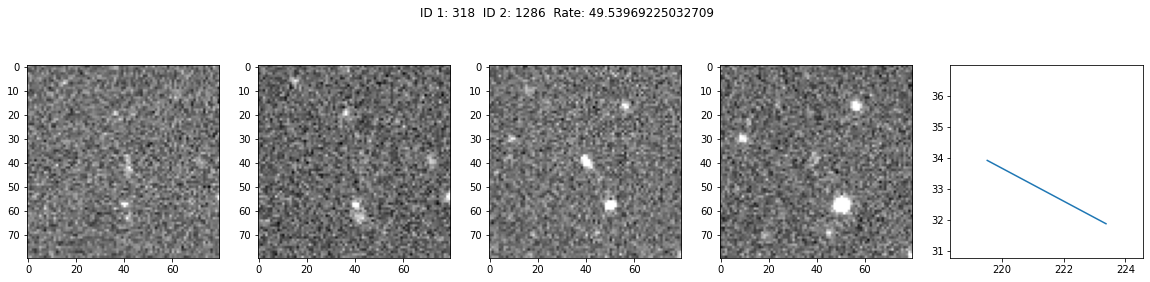

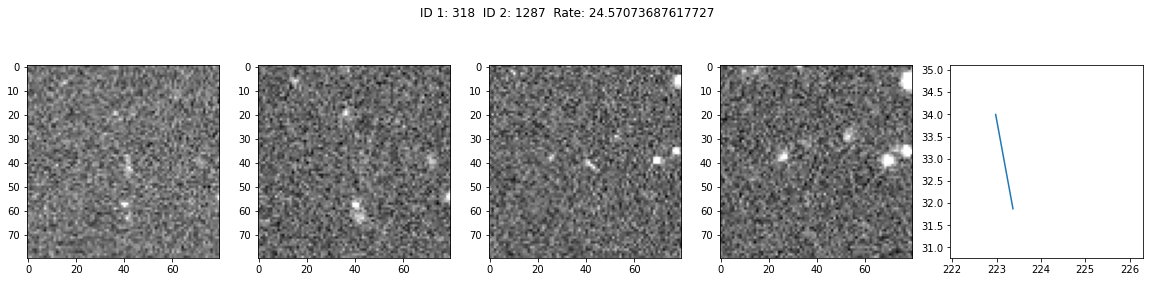

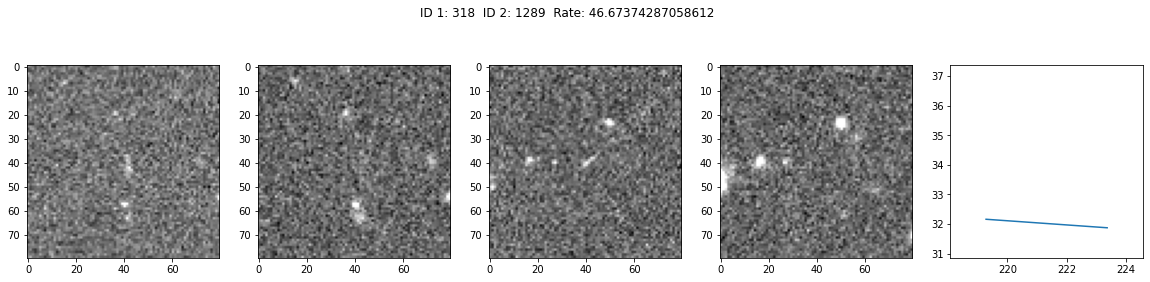

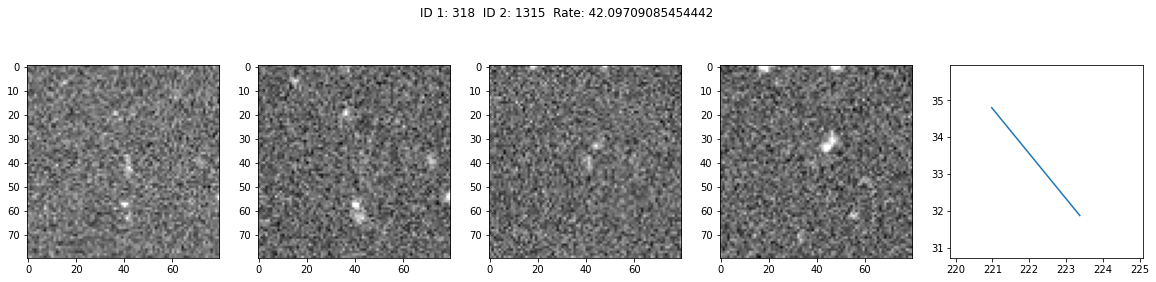

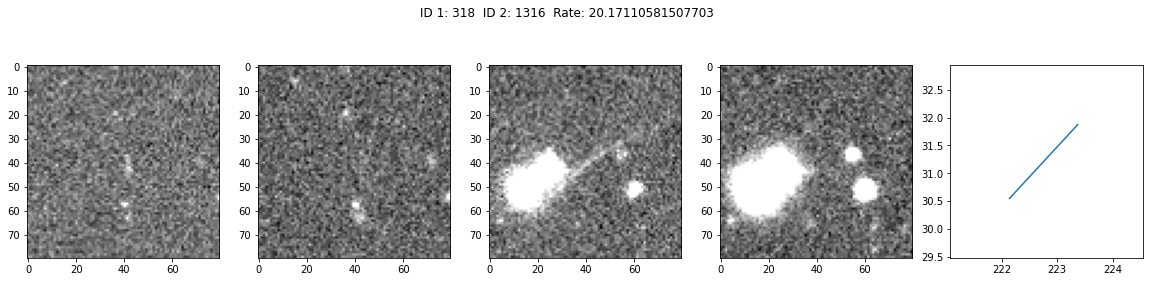

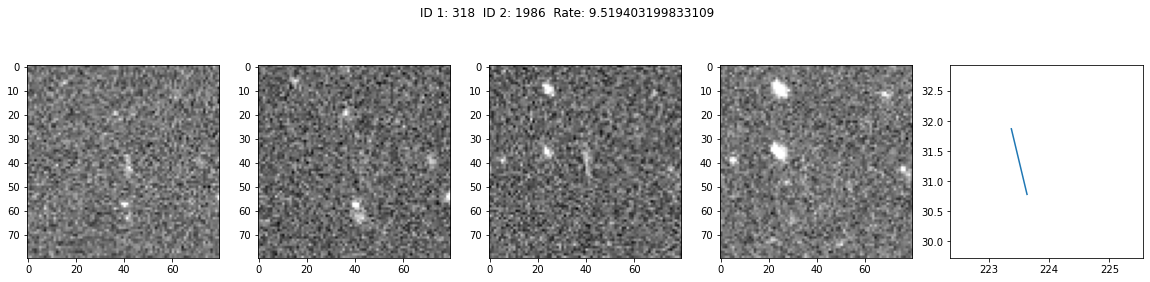

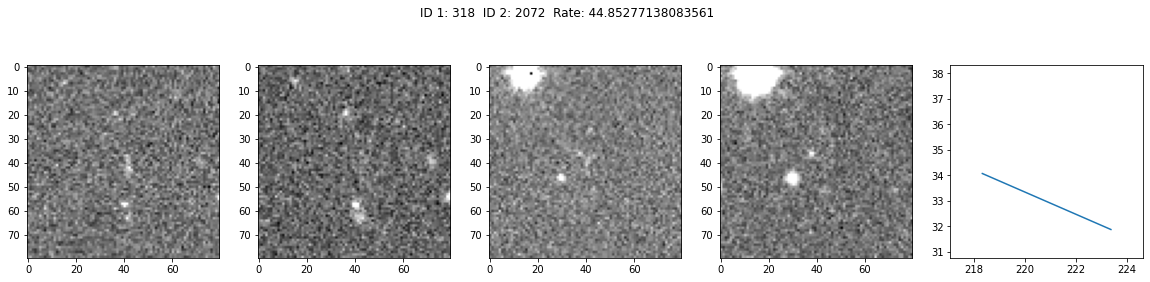

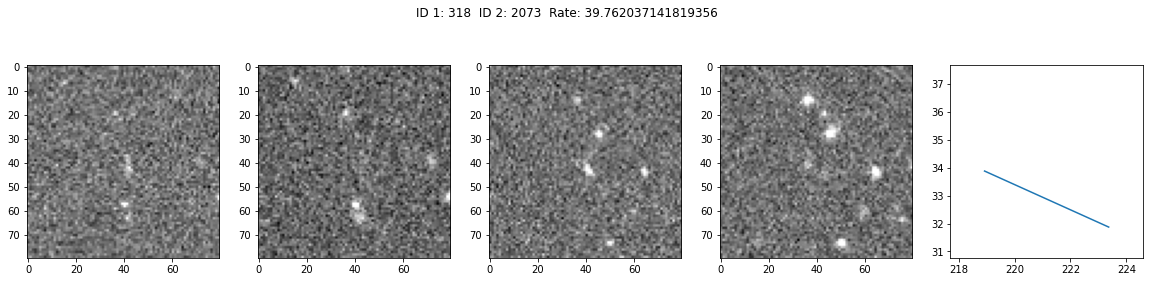

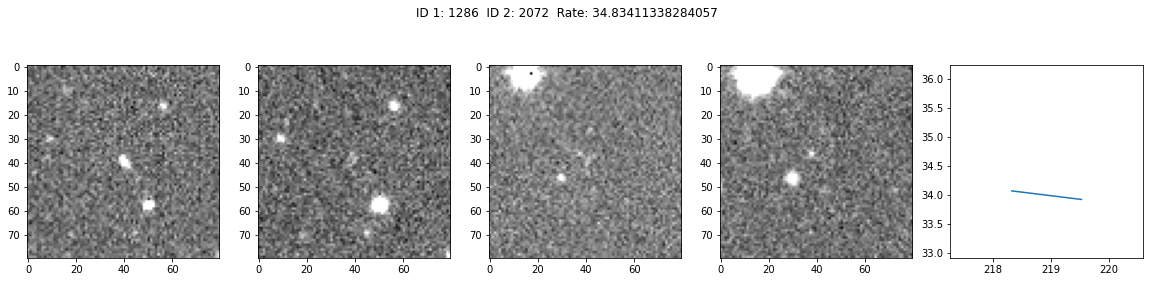

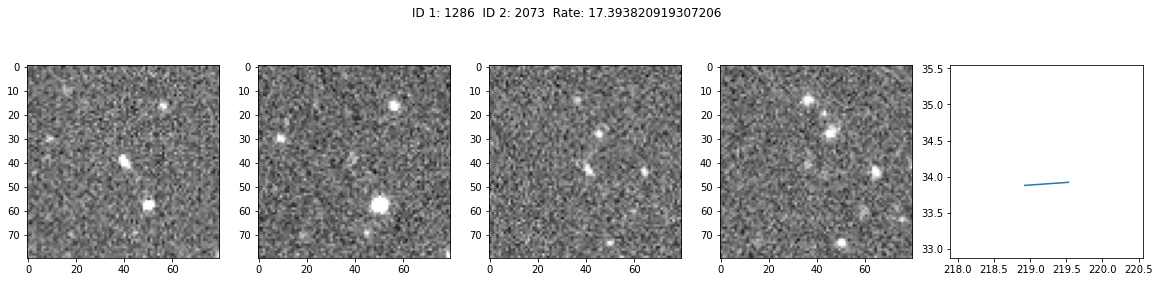

In [24]:
for i, j in tqdm(list(G.edges)):

    pos_i = positions[i]
    pos_j = positions[j]
    
    sci_i = arguments[indexes_list_flat[i]][0]
    time_i = float("0." + sci_i.split("/")[-1].split("_")[1][8:])
    sci_j = arguments[indexes_list_flat[j]][0]
    time_j = float("0." + sci_j.split("/")[-1].split("_")[1][8:])
    v = np.linalg.norm(np.array(pos_i) - np.array(pos_j))/np.abs(time_j - time_i)
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 4.5))
    fig.suptitle("ID 1: " + str(i) + "  ID 2: " + str(j) + "  Rate: " + str(v))
    ax[0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[2].imshow(norm_imgs_list_flat[j][0], cmap="gray")
    ax[3].imshow(norm_imgs_list_flat[j][1], cmap="gray")
    ax[4].plot(*np.array(positions)[[i, j]][:, :, 0].T)
    x_min, x_max = ax[4].get_xlim()
    y_min, y_max = ax[4].get_ylim()
    ax[4].set_xlim(x_min - 1, max(x_min + y_max - y_min, x_max) + 1)
    ax[4].set_ylim(y_min - 1, max(y_min + x_max - x_min, y_max) + 1)
    ax[4].set_aspect('equal', adjustable='box')

In [27]:
# linked detections are recorded here
detections = [
    [1337, 1357],
    [977, 1992, 2011, 2054],
    [337, 1596, 2518, 2540, 4412],
    [346, 549, 553, 2438, 2446, 4427],
    [450, 845, 1025, 1911, 1928]
]

# Check previous asteroids 

Using astcheck, I check to see if my streaks belong to previously discovered asteroids. The positions of my detections are also fed into sat_id (https://www.projectpluto.com/sat_id2.htm) to ensure they are not manmade satellites.

In [25]:
def get_obs_string(position_pix, sci_file, ref_file, title, radec=False):
    datetime = sci_file.split("/")[-1].split("_")[1]
    date = datetime[:4] + " " + datetime[4:6] + " " + datetime[6:8] + "." + datetime[8:]

    if not radec:
        wcs_ref = wcs.WCS(ref_file)

        ra, dec = wcs_ref.all_pix2world(np.array([position_pix]), 0, ra_dec_order=True)[0]
    else:
        ra, dec = position_pix

    c = SkyCoord(ra, dec, frame="icrs", unit="deg")
    ra_str = "{:02d} {:02d} {:06.3f}".format(int(c.ra.hms.h), int(c.ra.hms.m), c.ra.hms.s)
    dec_str = "{:02d} {:02d} {:05.2f}".format(abs(int(c.dec.dms.d)), abs(int(c.dec.dms.m)), abs(c.dec.dms.s))

    title = "_" * (12 - len(title)) + title
    return title + " " * 3 + date + ra_str + ("+" if dec >= 0 else "-") + dec_str + " " * 21 + "I41"
def check_obs(positions, sci_file, ref_file, thresh, verbose=False):
    datetime = sci_file.split("/")[-1].split("_")[1]

    date = datetime[:8]

    directory = "/media/etdisk15/ztf_neos/mpcorb/" + date + "/"

    wcs_ref = wcs.WCS(ref_file)
    ra, dec = zip(*wcs_ref.all_pix2world(np.array(positions), 0, ra_dec_order=True))
    
    obs_str = ""

    with open(directory + "obs.txt", "w") as f:

        for i in range(len(positions)):
            obs_str += get_obs_string([ra[i], dec[i]], sci_file, ref_file, str(i), radec=True) + "\n"
            f.write(get_obs_string([ra[i], dec[i]], sci_file, ref_file, str(i), radec=True) + "\n")

    lines = subprocess.run(["/home/fwang/lunar/astcheck", "obs.txt", "-r", str(thresh)], cwd=directory, capture_output=True,
                           universal_newlines=True).stdout

    info_line = False

    results = []

    for line in lines.split("\n"):
        if info_line:
            infos = line.split()
            if len(infos) == 7:
                results.append(True)
            else:
                results.append(False)
            info_line = False
        if len(line) > 0 and line[0] == "_":
            info_line = True
        if verbose:
            print(line)
    return results, ra, dec, obs_str

In [34]:
# directory containing the MPCORB file, which contains orbits of all known asteroids
directory = "/media/etdisk15/ztf_neos/mpcorb/20190605/"

results = []
for inds in detections:

    with open(directory + "obs.txt", "w") as f:

        for i in range(len(inds)):
            ra, dec = positions[inds[i]]
            sci_file, ref_file, diff_file= arguments[indexes_list_flat[inds[i]]]
            print("     " + get_obs_string([ra[0], dec[0]], sci_file, ref_file, str(0), radec=True)[5:])
            f.write(get_obs_string([ra[0], dec[0]], sci_file, ref_file, str(0), radec=True) + "\n")

    lines = subprocess.run(["/home/fwang/lunar/astcheck", "obs.txt", "-r", str(3000)], cwd=directory, capture_output=True,
                               universal_newlines=True).stdout

    info_line = False


    for line in lines.split("\n"):
        if info_line:
            infos = line.split()
            if len(infos) == 8:
                results.append(infos[0] + " " + infos[1])
            else:
                results.append(False)
            info_line = False
        if len(line) > 0 and "___________0" in line:
            info_line = True
        print(line)

print(results)

     ______0   2019 06 07.28431714 34 29.808+38 15 36.41                     I41
     ______0   2019 06 07.28524314 34 34.194+38 14 51.02                     I41
ASTCHECK version Jul  4 2020 21:43:28
1046005 objects
An explanation of these data is given at the bottom of the list.
                             d_ra   d_dec    dist    mag  motion 

___________0: 2324"/hr in RA, -2042"/hr in dec (0.02 hours)
The apparent motion and arc length for each object are shown,  followed
by a list of possible matches,  in order of increasing distance.  For
each match,  the separation is shown,  both in RA and dec,  and then
the 'total' separation,  all in arcseconds.  Next,  the magnitude and
apparent motion of the possible match are shown.  All motions are in
arcseconds per hour.

Run time: 0.0 seconds

     ______0   2019 06 07.24829915 42 44.268+30 59 08.02                     I41
     ______0   2019 06 07.31186315 40 42.378+30 55 43.07                     I41
     ______0   2019 06 07.31277815 

# View detections
The 1st, 2nd, and 4th asteroids are undiscovered while the 3rd corresponds to "2019 KA4" and the 5th to "2014 MF18"

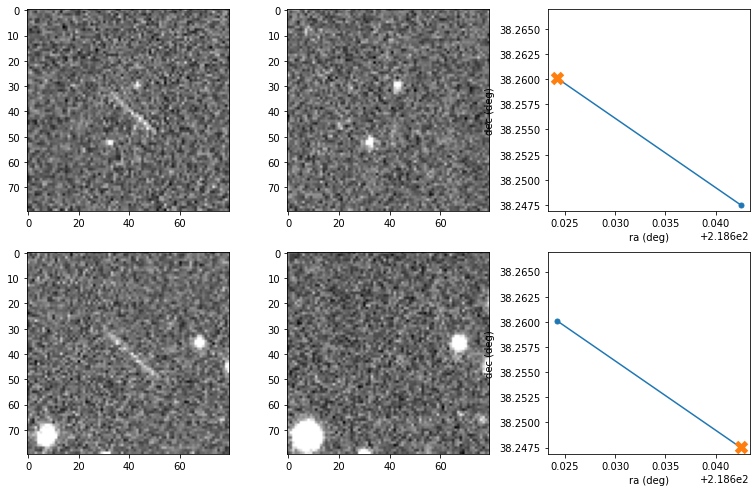

In [35]:
inds = detections[0]

fig, ax = plt.subplots(len(inds), 3, figsize=(11, 44/13 * len(inds)))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for ax_ind, i in enumerate(inds):
    datefracday = arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1]
    ax[ax_ind][0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[ax_ind][1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[ax_ind][2].plot(*np.array(positions)[inds][:, :, 0].T, marker=".", markersize=10)
    ax[ax_ind][2].plot(*np.array(positions)[[i]][:, :, 0].T, marker="x", markersize=10, markeredgewidth=5)
    x_min, x_max = ax[ax_ind][2].get_xlim()
    y_min, y_max = ax[ax_ind][2].get_ylim()
    ax[ax_ind][2].set_xlim(x_min, max(x_min + y_max - y_min, x_max))
    ax[ax_ind][2].set_ylim(y_min, max(y_min + x_max - x_min, y_max))
    ax[ax_ind][2].set_ylabel("dec (deg)")
    ax[ax_ind][2].set_xlabel("ra (deg)")
    ax[ax_ind][2].set_aspect('equal', adjustable='box')

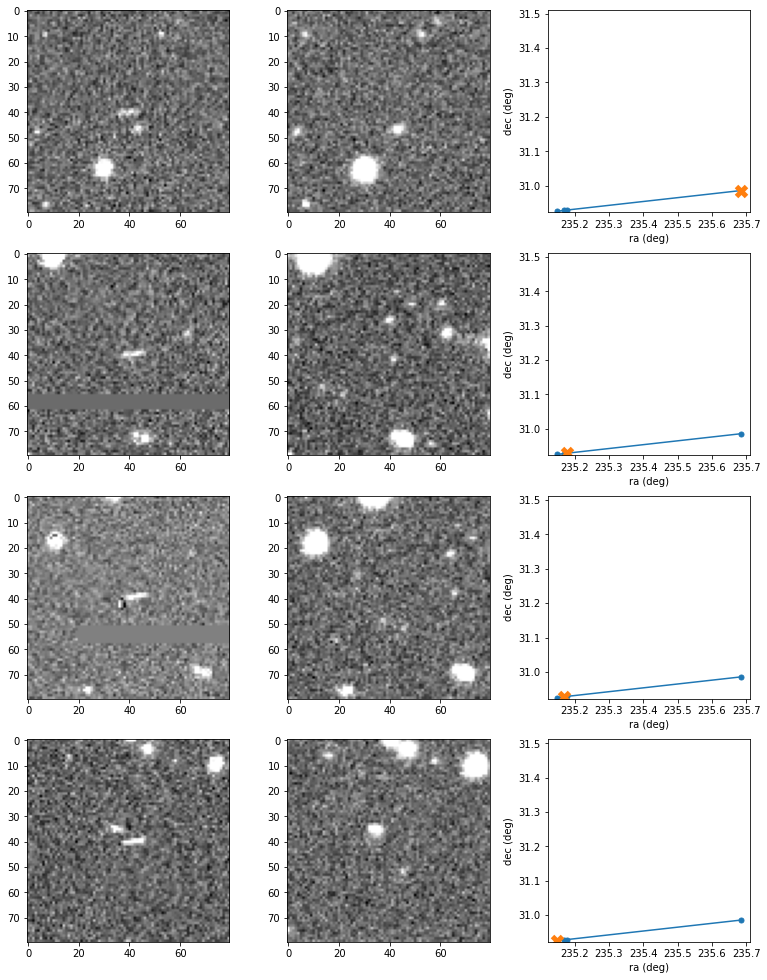

In [36]:
inds = detections[1]

fig, ax = plt.subplots(len(inds), 3, figsize=(11, 44/13 * len(inds)))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for ax_ind, i in enumerate(inds):
    datefracday = arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1]
    ax[ax_ind][0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[ax_ind][1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[ax_ind][2].plot(*np.array(positions)[inds][:, :, 0].T, marker=".", markersize=10)
    ax[ax_ind][2].plot(*np.array(positions)[[i]][:, :, 0].T, marker="x", markersize=10, markeredgewidth=5)
    x_min, x_max = ax[ax_ind][2].get_xlim()
    y_min, y_max = ax[ax_ind][2].get_ylim()
    ax[ax_ind][2].set_xlim(x_min, max(x_min + y_max - y_min, x_max))
    ax[ax_ind][2].set_ylim(y_min, max(y_min + x_max - x_min, y_max))
    ax[ax_ind][2].set_ylabel("dec (deg)")
    ax[ax_ind][2].set_xlabel("ra (deg)")
    ax[ax_ind][2].set_aspect('equal', adjustable='box')

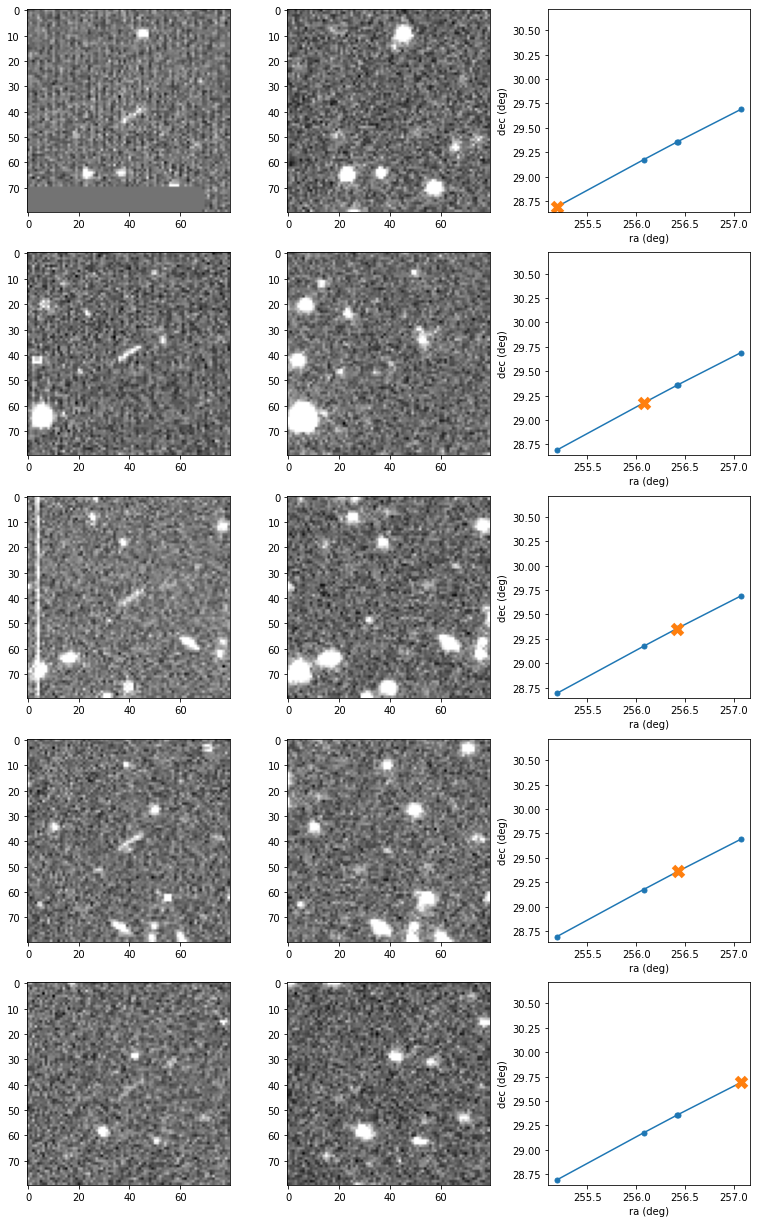

In [37]:
inds = detections[2]

fig, ax = plt.subplots(len(inds), 3, figsize=(11, 44/13 * len(inds)))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for ax_ind, i in enumerate(inds):
    datefracday = arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1]
    ax[ax_ind][0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[ax_ind][1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[ax_ind][2].plot(*np.array(positions)[inds][:, :, 0].T, marker=".", markersize=10)
    ax[ax_ind][2].plot(*np.array(positions)[[i]][:, :, 0].T, marker="x", markersize=10, markeredgewidth=5)
    x_min, x_max = ax[ax_ind][2].get_xlim()
    y_min, y_max = ax[ax_ind][2].get_ylim()
    ax[ax_ind][2].set_xlim(x_min, max(x_min + y_max - y_min, x_max))
    ax[ax_ind][2].set_ylim(y_min, max(y_min + x_max - x_min, y_max))
    ax[ax_ind][2].set_ylabel("dec (deg)")
    ax[ax_ind][2].set_xlabel("ra (deg)")
    ax[ax_ind][2].set_aspect('equal', adjustable='box')

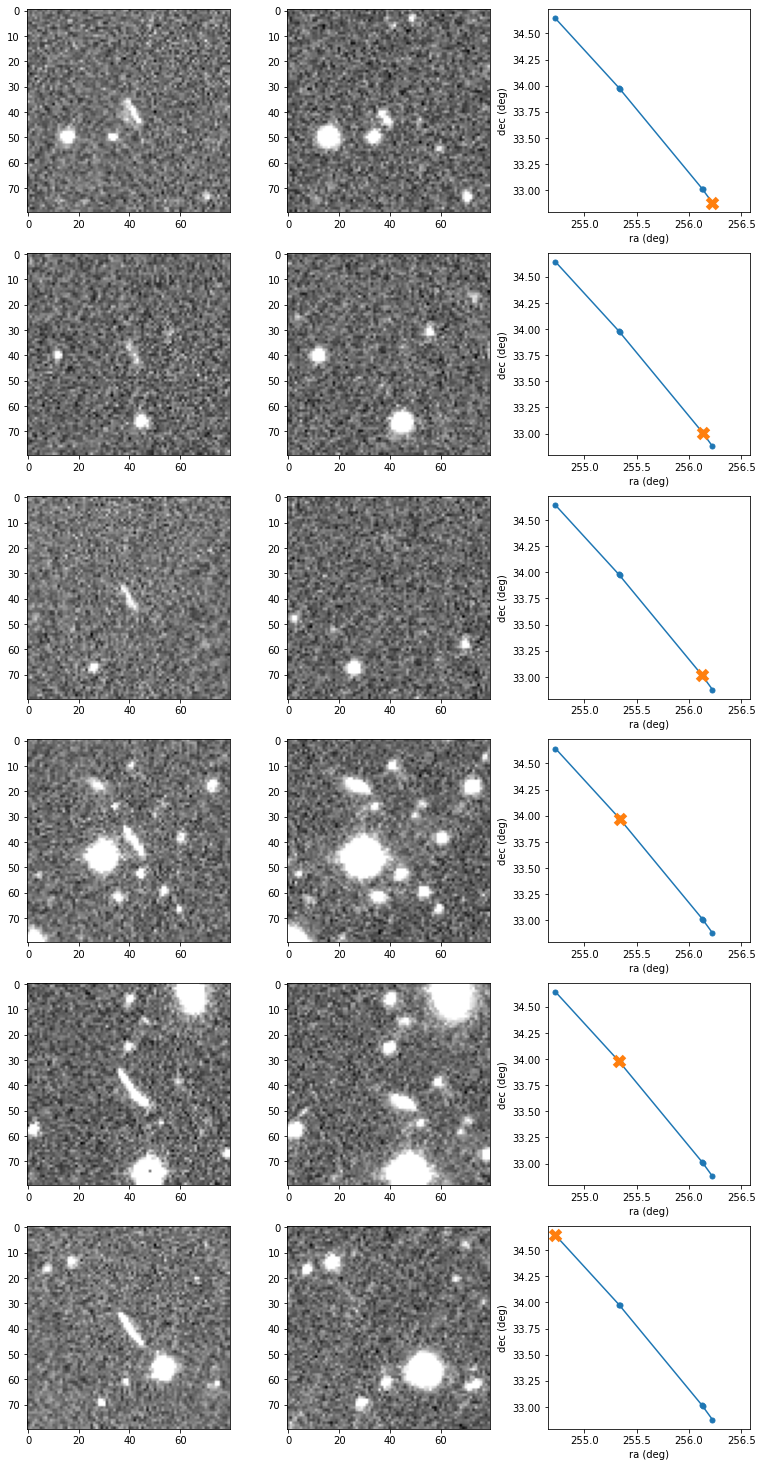

In [38]:
inds = detections[3]

fig, ax = plt.subplots(len(inds), 3, figsize=(11, 44/13 * len(inds)))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for ax_ind, i in enumerate(inds):
    datefracday = arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1]
    ax[ax_ind][0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[ax_ind][1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[ax_ind][2].plot(*np.array(positions)[inds][:, :, 0].T, marker=".", markersize=10)
    ax[ax_ind][2].plot(*np.array(positions)[[i]][:, :, 0].T, marker="x", markersize=10, markeredgewidth=5)
    x_min, x_max = ax[ax_ind][2].get_xlim()
    y_min, y_max = ax[ax_ind][2].get_ylim()
    ax[ax_ind][2].set_xlim(x_min, max(x_min + y_max - y_min, x_max))
    ax[ax_ind][2].set_ylim(y_min, max(y_min + x_max - x_min, y_max))
    ax[ax_ind][2].set_ylabel("dec (deg)")
    ax[ax_ind][2].set_xlabel("ra (deg)")
    ax[ax_ind][2].set_aspect('equal', adjustable='box')

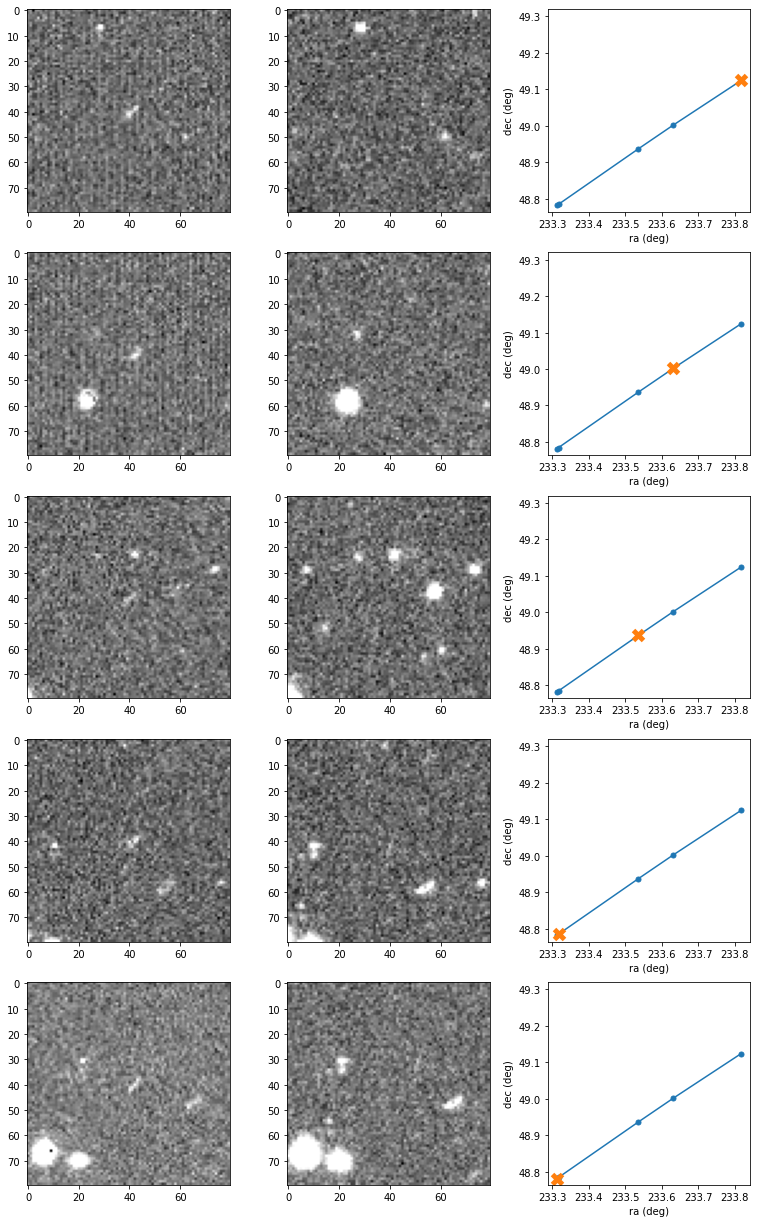

In [39]:
inds = detections[4]

fig, ax = plt.subplots(len(inds), 3, figsize=(11, 44/13 * len(inds)))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)
for ax_ind, i in enumerate(inds):
    datefracday = arguments[indexes_list_flat[i]][0].split("/")[-1].split("_")[1]
    ax[ax_ind][0].imshow(norm_imgs_list_flat[i][0], cmap="gray")
    ax[ax_ind][1].imshow(norm_imgs_list_flat[i][1], cmap="gray")
    ax[ax_ind][2].plot(*np.array(positions)[inds][:, :, 0].T, marker=".", markersize=10)
    ax[ax_ind][2].plot(*np.array(positions)[[i]][:, :, 0].T, marker="x", markersize=10, markeredgewidth=5)
    x_min, x_max = ax[ax_ind][2].get_xlim()
    y_min, y_max = ax[ax_ind][2].get_ylim()
    ax[ax_ind][2].set_xlim(x_min, max(x_min + y_max - y_min, x_max))
    ax[ax_ind][2].set_ylim(y_min, max(y_min + x_max - x_min, y_max))
    ax[ax_ind][2].set_ylabel("dec (deg)")
    ax[ax_ind][2].set_xlabel("ra (deg)")
    ax[ax_ind][2].set_aspect('equal', adjustable='box')

# Measuring the visual magnitude and motion rates
Using matplotlib's interactive features, the visual magnitude and motion rates are measured by outlining the streak and finding the two ends of the streak.

In [42]:
import subprocess
from astropy.io import fits
import sep
import skimage.morphology

def onclick(event):
    global coords
    
    x, y = event.xdata, event.ydata
    if x is not None and y is not None:
        
        coords.append((x, y))
        plt.scatter(x, y, marker="+", c="red", s=300, linewidths=1.5)

def extract_flux(diff_file, ref_file, bounds):
    global coords
    
    coords = []
    
    if ".fz" in diff_file:
        subprocess.run(["funpack", diff_file])
        diff_file = diff_file[:-3]
    
    head = fits.getheader(diff_file)

    wcs_diff = wcs.WCS(diff_file)
    wcs_ref = wcs.WCS(ref_file)
    bounds = wcs_diff.all_world2pix(wcs_ref.all_pix2world(bounds, 0, ra_dec_order=True), 0, ra_dec_order=True)
    
    diff = fits.getdata(diff_file)
    diff_crop = diff[int(bounds[0][1]):int(bounds[1][1]), int(bounds[0][0]):int(bounds[1][0]):-1].astype(np.float32)
    
    diff_bkg = sep.Background(diff_crop)
     
    fig, ax = plt.subplots()
    
    plt.imshow(np.clip((diff_crop - diff_bkg.back()) / diff_bkg.rms(), -5, 5), cmap="gray")

    fig.canvas.mpl_connect("button_press_event", onclick)
    return diff_crop, head
    
def get_vmag(diff_crop, head):
    mask = skimage.morphology.convex_hull.grid_points_in_poly(diff_crop.shape, coords)
    plt.figure()
    plt.imshow(mask.T)
    plt.figure()
    diff_copy = np.copy(diff_crop)
    diff_copy[~mask.T] = 0
    plt.imshow(diff_copy, cmap="gray")
    return -2.5 * np.log10(np.sum(diff_crop[mask.T])) + head["MAGZP"]
    
def onclick_speed(event):
    global coords, wcs_diff, speed
    
    x, y = event.xdata, event.ydata
    if x is not None and y is not None:
        
        coords.append((x, y))
        plt.scatter(x, y, marker="+", c="red", s=300, linewidths=1.5)
        if len(coords) == 2:
            x1, y1 = coords[0]
            x2, y2 = coords[1]
            ra1, dec1 = wcs_diff.all_pix2world([[x1 + x_min, y1 + y_min]], 0, ra_dec_order=True)[0]
            ra2, dec2 = wcs_diff.all_pix2world([[x2 + x_min, y2 + y_min]], 0, ra_dec_order=True)[0]
            coords.append((ra1, dec1, ra2, dec2))
            speed = (((ra2 - ra1) ** 2 + (dec2 - dec1) ** 2) ** 0.5) * 2880

def extract_speed(diff_file, ref_file, bounds):
    global coords, wcs_diff, x_min, y_min
    
    coords = []
    
    if ".fz" in diff_file:
        subprocess.run(["funpack", diff_file])
        diff_file = diff_file[:-3]
    
    head = fits.getheader(diff_file)

    wcs_diff = wcs.WCS(diff_file)
    wcs_ref = wcs.WCS(ref_file)
    bounds = wcs_diff.all_world2pix(wcs_ref.all_pix2world(bounds, 0, ra_dec_order=True), 0, ra_dec_order=True)
    x_min = bounds[0][0]
    y_min = bounds[0][1]
    
    diff = fits.getdata(diff_file)
    diff_crop = diff[int(bounds[0][1]):int(bounds[1][1]), int(bounds[0][0]):int(bounds[1][0]):-1].astype(np.float32)
    
    diff_bkg = sep.Background(diff_crop)
     
    fig, ax = plt.subplots()
    
    plt.imshow(np.clip((diff_crop - diff_bkg.back()) / diff_bkg.rms(), -5, 5), cmap="gray")

    fig.canvas.mpl_connect("button_press_event", onclick_speed)
    return diff_crop, head

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


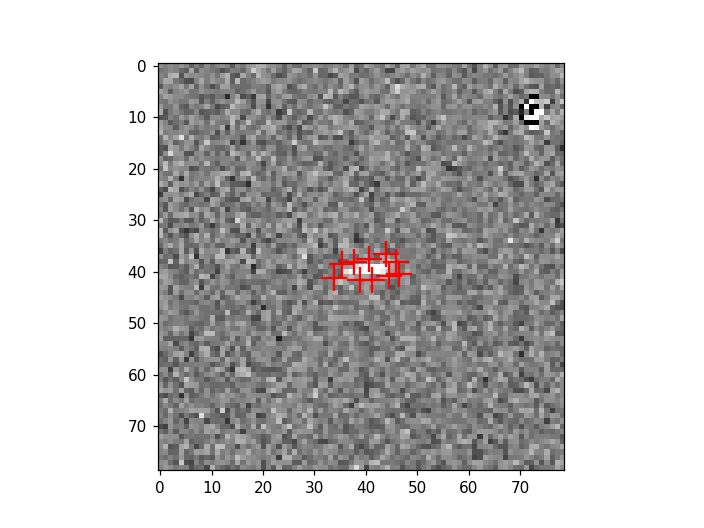

In [42]:
%matplotlib notebook
inds = detections[1]
index = inds[3]
diff_crop, head = extract_flux(arguments[indexes_list_flat[index][2]], arguments[indexes_list_flat[index][1]], top_bnds_list_flat[inds[i]])

<IPython.core.display.Javascript object>


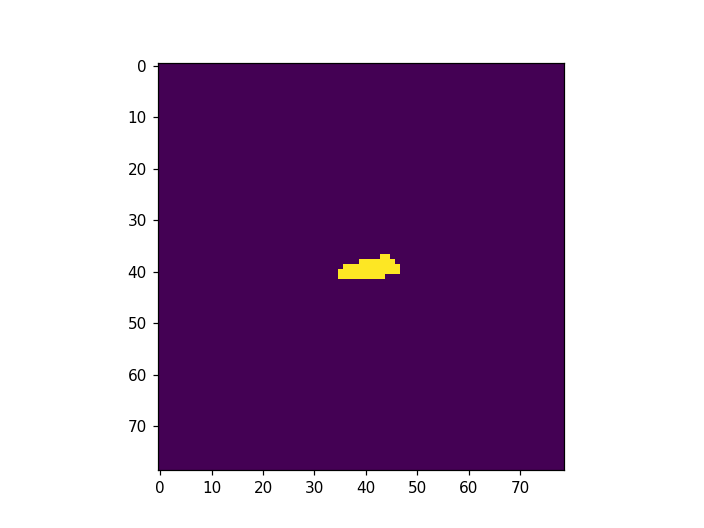

<IPython.core.display.Javascript object>


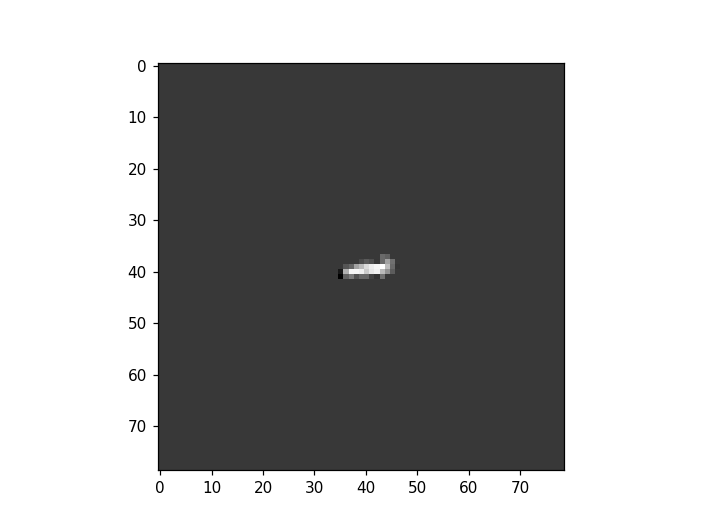

19.71152517604828


In [43]:
print(get_vmag(diff_crop, head))

[(35.373634668655725, 38.52345250545167), (37.72482514484619, 38.095963327962494), (40.50350479852585, 37.45472956172873), (43.92341821843928, 36.599751206750376), (45.84711951714057, 38.095963327962494), (46.48835328337434, 40.447153804152975), (44.56465198467305, 40.874642981642154), (41.14473856475962, 41.515876747875915), (38.79354808856914, 41.515876747875915), (33.8774225474436, 41.302132159131325)]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


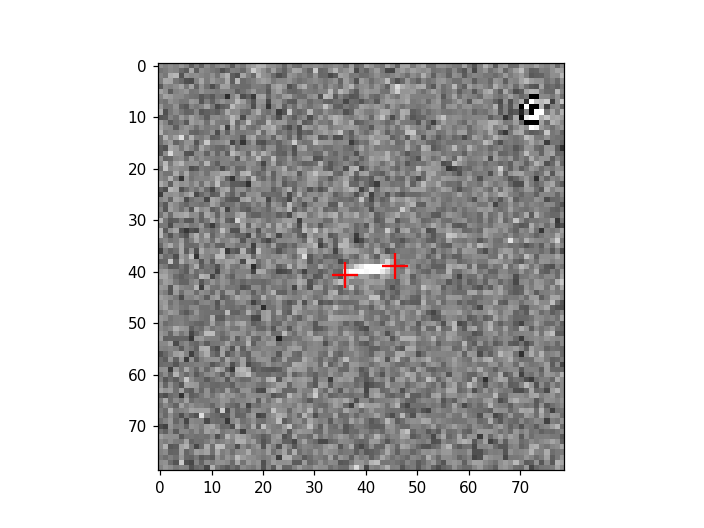

In [44]:
print(coords)
_ = extract_speed(arguments[indexes_list_flat[inds[i]]][2], arguments[indexes_list_flat[inds[i]]][1], top_bnds_list_flat[inds[i]])

In [45]:
print(speed)

9.18591076304982
